In [1]:
import json
from pathlib import Path
from itertools import combinations
from typing import Any

from tqdm import tqdm
import numpy as np
import pandas as pd
from datasets import load_dataset
import matplotlib.pyplot as plt

from asr.comparison import MultipleTextsAlignment, filter_correction_suggestions, TokenizedText, Substring
from asr.lm import SequenceScore, accept_suggestions_by_lm

## Loading results from disk

In [2]:
dataset = load_dataset('dangrebenkin/long_audio_youtube_lectures')['train']
name_to_transcription = dict(zip(dataset['name'], dataset['transcription']))

In [ ]:
# reading results

results_list = []
for filepath in Path('/home/oleg/pisets_test_results').glob('*.json'):
    data = json.loads(filepath.read_text())
    for pipeline_name, transcription in data['transcriptions'].items():
        results_list.append({
            'audio_name': data['audio_name'],
            'pipeline_name': pipeline_name,
            'transcription': transcription,
        })

results = pd.DataFrame(results_list)

tqdm.pandas()
results['alignment'] = results.progress_apply(
    lambda row: MultipleTextsAlignment.from_strings(
        name_to_transcription[row['audio_name']],
        row['transcription']
    ),
    axis='columns'
)
del results['transcription']
results['wer'] = results['alignment'].apply(lambda al: al.wer()['wer'])

# reading results with token-wise Whisper scores

results_with_scores = []

for filepath in Path('/home/oleg/pisets_test_results_with_scores').glob('*.json'):
    with open(filepath) as f:
        data = json.load(f)

        # reconstructing dataclasses from dicts
        data['tokenized_text']['tokens'] = [
            Substring(**x) for x in data['tokenized_text']['tokens']
        ]
        data['tokenized_text'] = TokenizedText(**data['tokenized_text'])

        data['pipeline_name'] = data.pop('transcriber_name')
        results_with_scores.append(data)

results_with_scores = pd.DataFrame(results_with_scores)
results_with_scores['alignment'] = results_with_scores.progress_apply(
    lambda row: MultipleTextsAlignment.from_strings(
        name_to_transcription[row['audio_name']],
        row['tokenized_text']
    ),
    axis='columns'
)
del results_with_scores['tokenized_text']
results_with_scores['wer'] = results_with_scores['alignment'].apply(lambda al: al.wer()['wer'])

# concatenating

results = pd.concat([results, results_with_scores], axis='rows', ignore_index=True)

  0%|          | 0/77 [00:00<?, ?it/s]

100%|██████████| 7/7 [00:02<00:00,  2.99it/s]


In [4]:
results

,audio_name,pipeline_name,alignment,wer,scores_per_word
0,kolodezev,Baseline Whisper longform,MultipleTextsAlignment(text1=TokenizedText(tex...,0.161696,NaN
1,zhirinovsky,Pisets WhisperV3 no-VAD (segments 1s-20s),MultipleTextsAlignment(text1=TokenizedText(tex...,0.052458,NaN
2,zhirinovsky,Pisets WhisperV3 no-VAD stretched (segments 1s...,MultipleTextsAlignment(text1=TokenizedText(tex...,0.064849,NaN
3,lankov,Pisets WhisperV3 no-VAD Podlodka (segments 1s-...,MultipleTextsAlignment(text1=TokenizedText(tex...,0.097544,NaN
4,kolodezev,Baseline Whisper longform conditioned,MultipleTextsAlignment(text1=TokenizedText(tex...,0.276680,NaN
...,...,...,...,...,...
2,lankov,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,MultipleTextsAlignment(text1=TokenizedText(tex...,0.089934,"[[-0.4045039713382721], [-0.25986623764038086]..."
3,zaliznyak,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,MultipleTextsAlignment(text1=TokenizedText(tex...,0.112038,"[[-0.1870197057723999, -6.603976362384856e-05]..."
4,savvateev,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,MultipleTextsAlignment(text1=TokenizedText(tex...,0.162985,"[[-0.6434793472290039], [-0.008379065431654453..."
5,kolodezev,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,MultipleTextsAlignment(text1=TokenizedText(tex...,0.127201,"[[-1.3415793180465698, -0.010715918615460396],..."


## WER results

In [5]:
results.pivot_table(values='wer', index='pipeline_name', columns='audio_name')

audio_name,harvard,kolodezev,lankov,savvateev,tuberculosis,zaliznyak,zhirinovsky
pipeline_name,,,,,,,
Baseline Whisper longform,0.010929,0.161696,0.103079,0.206186,0.169576,0.158086,0.043371
Baseline Whisper longform conditioned,0.050546,0.276680,0.123833,0.230241,0.139963,0.678753,0.064436
Baseline Whisper pipeline,0.045537,0.155228,0.147354,0.192440,0.199501,0.131617,0.115655
Pisets WhisperV3 (segments 10s-30s),0.011840,0.134028,0.131788,0.182622,0.159913,0.113125,0.067741
Pisets WhisperV3 (segments 1s-20s),0.015938,0.129357,0.087513,0.216986,0.131234,0.116751,0.060306
Pisets WhisperV3 Podlodka (segments 1s-20s),0.030965,0.102767,0.097544,0.291114,0.076372,0.116389,0.088806
Pisets WhisperV3 no-VAD (segments 1s-20s),0.015938,0.129357,0.087513,0.186058,0.131234,0.106599,0.052458
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores,0.016849,0.127201,0.089934,0.162985,0.129676,0.112038,0.053697
Pisets WhisperV3 no-VAD Podlodka (segments 1s-20s),0.030965,0.102767,0.097544,0.259205,0.076372,0.106962,0.081371


## Uncertainty with model disagreement

"Method 3: LM filtering" may take a lot of time. It will be saved on disk as soon as it is calculated.

In [97]:
uncertainty_results = []

scorer = SequenceScore('ai-forever/rugpt3large_based_on_gpt2')

for audio_name in name_to_transcription:

    base_pipeline_name = 'Pisets WhisperV3 no-VAD (segments 1s-20s) with scores'

    truth_vs_base: MultipleTextsAlignment = results.query(
        f'audio_name == "{audio_name}" and pipeline_name == "{base_pipeline_name}"'
    ).iloc[0]['alignment']

    for additional_pipeline_name in [
        'W2V2 Golos LM',
        'Pisets WhisperV3 no-VAD stretched (segments 1s-20s)',
    ]:
        additional_predictions: TokenizedText = results.query(
            f'audio_name == "{audio_name}" and pipeline_name == "{additional_pipeline_name}"'
        ).iloc[0]['alignment'].text2

        base_vs_additional = MultipleTextsAlignment.from_strings(truth_vs_base.text2, additional_predictions)

        # method 1: no filtering
        print(base_pipeline_name, additional_pipeline_name, 'all diffs')

        is_uncertain = base_vs_additional.get_uncertainty_mask()
        uncertainty_results.append({
            'audio_name': audio_name,
            'base_pipeline': base_pipeline_name,
            'additional_pipeline': additional_pipeline_name,
            'method': 'all diffs',
            'mask': is_uncertain,
            'metrics': truth_vs_base.wer(uncertainty_mask=is_uncertain)
        })

        # method 2: filtering
        print(base_pipeline_name, additional_pipeline_name, 'filtered diffs')

        correction_indices = filter_correction_suggestions(base_vs_additional, skip_word_form_change=False, pbar=False)
        is_uncertain = base_vs_additional.get_uncertainty_mask(match_indices=correction_indices)
        uncertainty_results.append({
            'audio_name': audio_name,
            'base_pipeline': base_pipeline_name,
            'additional_pipeline': additional_pipeline_name,
            'method': 'filtered diffs',
            'mask': is_uncertain,
            'metrics': truth_vs_base.wer(uncertainty_mask=is_uncertain)
        })

        # method 3: LM filtering
        print(base_pipeline_name, additional_pipeline_name, 'LM filtered diffs')

        cache_path = (
            Path('/home/oleg/pisets_test_results_lm')
            / f'[{audio_name}] [{base_pipeline_name}] [{additional_pipeline_name}].json'
        )
        if cache_path.is_file():
            lm_filtered_suggestion_indices = json.loads(cache_path.read_text())['indices']
        else:
            lm_filtered_suggestion_indices = accept_suggestions_by_lm(
                base_vs_additional,
                [i for i, m in enumerate(base_vs_additional.matches) if not m.is_equal],
                scorer,
                pbar=False,
                verbose=True,
            )
            cache_path.parent.mkdir(parents=True, exist_ok=True)
            cache_path.write_text(json.dumps({'indices': lm_filtered_suggestion_indices}))
        is_uncertain = base_vs_additional.get_uncertainty_mask(match_indices=lm_filtered_suggestion_indices)
        uncertainty_results.append({
            'audio_name': audio_name,
            'base_pipeline': base_pipeline_name,
            'additional_pipeline': additional_pipeline_name,
            'method': 'LM filtered diffs',
            'mask': is_uncertain,
            'metrics': truth_vs_base.wer(uncertainty_mask=is_uncertain)
        })

Pisets WhisperV3 no-VAD (segments 1s-20s) with scores W2V2 Golos LM all diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores W2V2 Golos LM filtered diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores W2V2 Golos LM LM filtered diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores Pisets WhisperV3 no-VAD stretched (segments 1s-20s) all diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores Pisets WhisperV3 no-VAD stretched (segments 1s-20s) filtered diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores Pisets WhisperV3 no-VAD stretched (segments 1s-20s) LM filtered diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores W2V2 Golos LM all diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores W2V2 Golos LM filtered diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores W2V2 Golos LM LM filtered diffs
Pisets WhisperV3 no-VAD (segments 1s-20s) with scores Pisets WhisperV3 no-VAD stretched (segments 1s-20s) all diffs
Pisets WhisperV3 no-VAD (segm

## Uncertainty with Whisper sequence score

In [98]:
for audio_name in name_to_transcription:

    base_pipeline_name = 'Pisets WhisperV3 no-VAD (segments 1s-20s) with scores'

    row = results.query(
        f'audio_name == "{audio_name}" and pipeline_name == "{base_pipeline_name}"'
    ).iloc[0]
    truth_vs_base = row['alignment']
    scores_per_word = row['scores_per_word']

    reductions = {'min': min, 'mean': np.mean, 'sum': np.sum}
    log_proba_thresholds = np.linspace(-1.5, -0.1, num=15)

    for reduction_name, reduction_fn in reductions.items():
        for log_proba_threshold in log_proba_thresholds:
            is_uncertain = np.array([reduction_fn(s) for s in scores_per_word]) < log_proba_threshold
            uncertainty_results.append({
                'audio_name': audio_name,
                'base_pipeline': base_pipeline_name,
                'method': f'WhisperLogProba_{reduction_name}',
                't': log_proba_threshold,
                'mask': is_uncertain,
                'metrics': truth_vs_base.wer(uncertainty_mask=is_uncertain),
            })

/home/oleg/pisets/asr/comparison.py:347: RuntimeWarning: invalid value encountered in scalar divide
  uncertain_n_correct / (uncertain_n_correct + uncertain_n_incorrect)
/home/oleg/pisets/asr/comparison.py:350: RuntimeWarning: invalid value encountered in scalar divide
  results['uncertain_n_incorrect']


In [99]:
uncertainty_results = pd.DataFrame(uncertainty_results)
uncertainty_results

,audio_name,base_pipeline,additional_pipeline,method,mask,metrics,t
0,zaliznyak,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,W2V2 Golos LM,all diffs,"[False, False, False, False, False, False, Fal...","{'wer': 0.112037708484409, 'certain_n_correct'...",NaN
1,zaliznyak,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,W2V2 Golos LM,filtered diffs,"[False, False, False, False, False, False, Fal...","{'wer': 0.112037708484409, 'certain_n_correct'...",NaN
2,zaliznyak,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,W2V2 Golos LM,LM filtered diffs,"[False, False, False, False, False, False, Fal...","{'wer': 0.112037708484409, 'certain_n_correct'...",NaN
3,zaliznyak,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,Pisets WhisperV3 no-VAD stretched (segments 1s...,all diffs,"[False, False, False, False, False, False, Fal...","{'wer': 0.112037708484409, 'certain_n_correct'...",NaN
4,zaliznyak,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,Pisets WhisperV3 no-VAD stretched (segments 1s...,filtered diffs,"[False, False, False, False, False, False, Fal...","{'wer': 0.112037708484409, 'certain_n_correct'...",NaN
...,...,...,...,...,...,...,...
352,tuberculosis,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,NaN,WhisperLogProba_sum,"[False, False, False, True, False, False, Fals...","{'wer': 0.12967581047381546, 'certain_n_correc...",-0.5
353,tuberculosis,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,NaN,WhisperLogProba_sum,"[False, False, False, True, False, False, Fals...","{'wer': 0.12967581047381546, 'certain_n_correc...",-0.4
354,tuberculosis,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,NaN,WhisperLogProba_sum,"[True, False, False, True, False, False, False...","{'wer': 0.12967581047381546, 'certain_n_correc...",-0.3
355,tuberculosis,Pisets WhisperV3 no-VAD (segments 1s-20s) with...,NaN,WhisperLogProba_sum,"[True, False, False, True, False, False, False...","{'wer': 0.12967581047381546, 'certain_n_correc...",-0.2


## Ensembling uncertainty estimation methods

In [100]:
ensemble_uncertainty_results = []

for audio_name in name_to_transcription:

    base_pipeline_name = 'Pisets WhisperV3 no-VAD (segments 1s-20s) with scores'
    additional_pipeline_name = 'W2V2 Golos LM'

    truth_vs_base = results.query(
        f'audio_name == "{audio_name}" and pipeline_name == "{base_pipeline_name}"'
    ).iloc[0]['alignment']

    t = -1
    row1 = uncertainty_results.query(
        f'audio_name == "{audio_name}"'
        f' and base_pipeline == "{base_pipeline_name}"'
        ' and method == "WhisperLogProba_sum"'
        f' and t > {t - 0.001}'
        f' and t < {t + 0.001}'
    ).iloc[0]

    row2 = uncertainty_results.query(
        f'audio_name == "{audio_name}"'
        f' and base_pipeline == "{base_pipeline_name}"'
        f' and additional_pipeline == "{additional_pipeline_name}"'
        ' and method == "LM filtered diffs"'
    ).iloc[0]

    is_uncertain = row1['mask'] | row2['mask']

    ensemble_uncertainty_results.append({
            'audio_name': audio_name,
            'base_pipeline': base_pipeline_name,
            'additional_pipeline': additional_pipeline_name,
            'method': f'LM filtered diffs + WhisperLogProba_sum (t={t})',
            'mask': is_uncertain,
            'metrics': truth_vs_base.wer(uncertainty_mask=is_uncertain),
        })

ensemble_uncertainty_results = pd.DataFrame(ensemble_uncertainty_results)
uncertainty_results = pd.concat([uncertainty_results, ensemble_uncertainty_results], axis='rows', ignore_index=True)

## Uncertainty plots

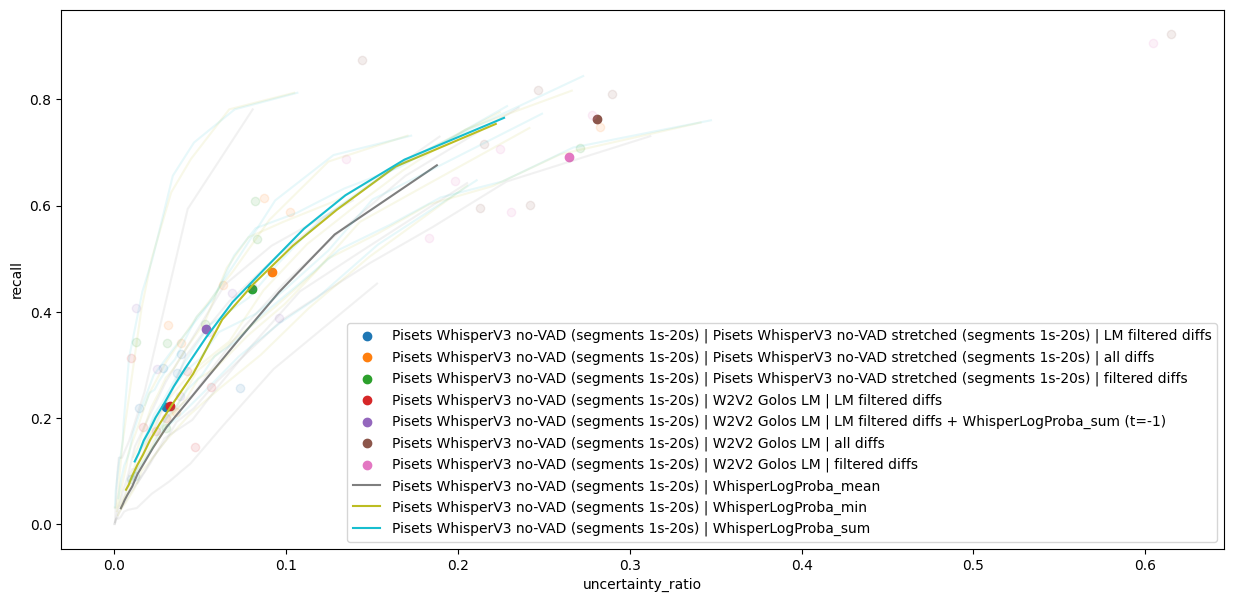

In [101]:
plt.figure(figsize=(15, 7))

show_for_all_datasets = True

x_statistics = 'uncertainty_ratio'
y_statistics = 'recall'

for i, ((base_pipeline, additional_pipeline, method), group_loc) in enumerate(
    uncertainty_results.groupby(['base_pipeline', 'additional_pipeline', 'method']).groups.items()
):
    group = uncertainty_results.loc[group_loc]
    color = f'C{i}'
    has_t = not pd.isna(group['t'].values[0]) and group['t'].nunique() > 1
    
    if not pd.isna(additional_pipeline):
        label = f'{base_pipeline.replace(" with scores", "")} | {additional_pipeline} | {method}'
    else:
        label = f'{base_pipeline.replace(" with scores", "")} | {method}'

    if not has_t:
        # no parameter, scatter plot
        assert group.audio_name.nunique() == len(group)
        xs = [m[x_statistics] for m in group.metrics]
        ys = [m[y_statistics] for m in group.metrics]
        assert len(xs) == len(name_to_transcription)
        if show_for_all_datasets:
            plt.scatter(xs, ys, alpha=0.1, color=color)
        plt.scatter([np.mean(xs)], [np.mean(ys)], label=label, color=color)
    
    else:
        # has a parameter, line plot
        t_range = sorted(group['t'].unique())

        xs = []
        ys = []
        for t in t_range:
            group_for_t = group[group['t'] == t]
            assert group_for_t.audio_name.nunique() == len(group_for_t)
            xs.append([m[x_statistics] for m in group_for_t.metrics])
            ys.append([m[y_statistics] for m in group_for_t.metrics])

        xs = np.array(xs).T  # shape: (n_audios, n_t_values)
        ys = np.array(ys).T  # shape: (n_audios, n_t_values)
        assert len(xs) == len(name_to_transcription)

        if show_for_all_datasets:
            for _xs, _ys in zip(xs, ys):
                plt.plot(_xs, _ys, alpha=0.1, color=color)
        plt.plot(xs.mean(axis=0), ys.mean(axis=0), label=label, color=color)

plt.xlabel(x_statistics)
plt.ylabel(y_statistics)
plt.legend()
plt.show()

## Visual analysis of uncertainty highlighting

In [124]:
audio_name = 'zaliznyak'

base_pipeline_name = 'Pisets WhisperV3 no-VAD (segments 1s-20s) with scores'
additional_pipeline_name = 'W2V2 Golos LM'

is_uncertain = uncertainty_results.query(
    f'audio_name == "{audio_name}"'
    f' and base_pipeline == "{base_pipeline_name}"'
    ' and method == "LM filtered diffs + WhisperLogProba_sum (t=-1)"'
).iloc[0]['mask']

truth_vs_base = results.query(
    f'audio_name == "{audio_name}"'
    f' and pipeline_name == "{base_pipeline_name}"'
).iloc[0]['alignment']

truth_vs_additional = results.query(
    f'audio_name == "{audio_name}"'
    f' and pipeline_name == "{additional_pipeline_name}"'
).iloc[0]['alignment']

base_vs_additional = MultipleTextsAlignment.from_strings(truth_vs_base.text2, truth_vs_additional.text2)
diffs_to_highlight = [i for i, m in enumerate(base_vs_additional.matches) if is_uncertain[m.start1:m.end1].any()]
print(base_vs_additional.substitute(show_in_braces=diffs_to_highlight))

 Вторая строка фактически была в очень плохом состоянии, но удалось однако же все-таки ее практически целиком восстановить. Я не буду вам выписывать все скобки неполной видимости, это не очень в данном случае существенно, поскольку в конечном счете результат совершенно надежный {остался|оказался} восстановлен.  И читается следующее. Адресат. Вот практически все, что сохранилось от этой грамоты, это адресная формула.  поклон от {Клименте|элементе}  и от {Марьи|марья} к Петку {Копарину. Имя Петко|кабаринаимя пятко} находится далеко.  скажем своде тупикова которым постоянно пользуемся своде древнерусских имен {петка|пятко} упоминается 11 раз то есть один из разных персонажей но это очень понятно это одно из {элементов а|имен того} типа как какой-нибудь шестак {3 2|третей второй} и так далее когда  Долго не думая, детей называли просто по счету появления, и больше ничего.  Что касается опарина, то, конечно, он происходит от имени опара. Но опара – это такое тесто, вылезающее из катки. Я оч